In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math

In [2]:
path = 'Donnees_TD2_2018/0750am-0805am/trajectories-0750am-0805am.txt'
data = pd.read_csv(path, engine='python', sep = r'\s+', names = ["VehicleID","FrameID", "TotalFrames", "GlobalTime", 
                                                                 "LocalX", "LocalY", "GlobalX", "GlobalY", 
                                                                 "VehicleLength", "VehicleWidth", "VehicleClass", 
                                                                 "VehicleVelocity", "VehicleAcceleration", 
                                                                 "LaneIdentification", "PrecedingVehicle", 
                                                                 "FollowingVehicle", "Spacing", "Headway"])

In [3]:
data.head()

,VehicleID,FrameID,TotalFrames,GlobalTime,LocalX,LocalY,GlobalX,GlobalY,VehicleLength,VehicleWidth,VehicleClass,VehicleVelocity,VehicleAcceleration,LaneIdentification,PrecedingVehicle,FollowingVehicle,Spacing,Headway
0,2,13,437,1118846980200,16.467,35.381,6451137.641,1873344.962,14.5,4.9,2,40.0,0.0,2,0,0,0.0,0.0
1,2,14,437,1118846980300,16.447,39.381,6451140.329,1873342.000,14.5,4.9,2,40.0,0.0,2,0,0,0.0,0.0
2,2,15,437,1118846980400,16.426,43.381,6451143.018,1873339.038,14.5,4.9,2,40.0,0.0,2,0,0,0.0,0.0
3,2,16,437,1118846980500,16.405,47.380,6451145.706,1873336.077,14.5,4.9,2,40.0,0.0,2,0,0,0.0,0.0
4,2,17,437,1118846980600,16.385,51.381,6451148.395,1873333.115,14.5,4.9,2,40.0,0.0,2,0,0,0.0,0.0


In [4]:
# data.to_csv("Donnees_produites/trajectories_clean")

In [5]:
# Exercice 1
idN      = 2
idNplus1 = 13

# Sélection des données pour une paire de véhicules qui se suivent 
vehiculeN      = data.loc[(data['VehicleID'] == idN) & (data['FollowingVehicle'] == idNplus1)] # n
vehiculeNplus1 = data.loc[(data['VehicleID'] == idNplus1) & (data['PrecedingVehicle'] == idN)] # n + 1

In [6]:
T     = 1.6 # T entre 1.0 et 2.2 s (1.55 s en moyenne)

T = T * 1000 # Conversion en ms

speedCurVeh         = []
speedPreVeh         = []
acceCurVeh          = []
vehicleDiffVelocity = []

for i in range(len(vehiculeNplus1) - int(T/100)):
    speedCurVeh.append(vehiculeNplus1['VehicleVelocity'].loc[(vehiculeNplus1['GlobalTime'] 
                                                         == vehiculeNplus1['GlobalTime'].iloc[i])].values[0])
    speedPreVeh.append(vehiculeN['VehicleVelocity'].loc[(vehiculeN['GlobalTime'] 
                                                          == vehiculeN['GlobalTime'].iloc[i])].values[0])
    acceCurVeh.append(vehiculeNplus1['VehicleAcceleration'].loc[(vehiculeNplus1['GlobalTime'] 
                                                                 == vehiculeNplus1['GlobalTime'].iloc[i] + T)].values[0])
    diff = speedPreVeh[i] - speedCurVeh[i]
    vehicleDiffVelocity.append(diff)

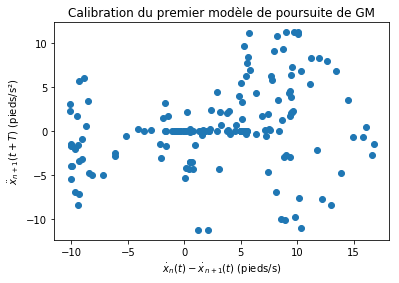

In [7]:
plt.scatter(vehicleDiffVelocity, acceCurVeh)

plt.xlabel(r'$\dot x_{n}(t) - \dot x_{n+1}(t)$ (pieds/s)')
plt.ylabel(r'$\ddot x_{n+1}(t+T)$ (pieds/s²)')
plt.title('Calibration du premier modèle de poursuite de GM')
plt.show()

In [8]:
acceCurVeh = np.asarray(acceCurVeh)
x = acceCurVeh[:,np.newaxis]
alpha = np.linalg.lstsq(x, vehicleDiffVelocity, rcond=None)[0][0]

print("alpha = %.3f"%alpha) # α entre 0.17 et 0.74 1/s (0.37 en moyenne)

alpha = 0.428


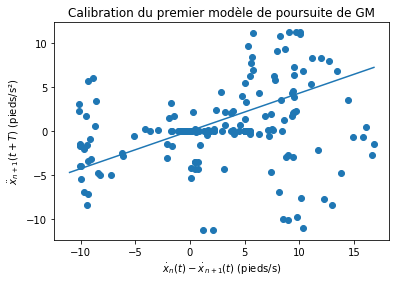

In [9]:
t_min = -11
t_max = 17
step  = (t_max-t_min)/len(vehicleDiffVelocity)

t = np.arange(t_min, t_max, step)
y = alpha*t

plt.scatter(vehicleDiffVelocity, acceCurVeh,  label = 'Véhicule #2')
plt.plot(t,y)

plt.xlabel(r'$\dot x_{n}(t) - \dot x_{n+1}(t)$ (pieds/s)')
plt.ylabel(r'$\ddot x_{n+1}(t+T)$ (pieds/s²)')
plt.title('Calibration du premier modèle de poursuite de GM')
# plt.savefig('Donnees_produites/Figures/calibration_premier_modele_GM.eps', format='eps')
plt.show()

In [10]:
# Exercice 2
idN      = 21
idNplus1 = 25

vehiculeN      = data.loc[(data['VehicleID'] == idN) & (data['FollowingVehicle'] == idNplus1)] # n
vehiculeNplus1 = data.loc[(data['VehicleID'] == idNplus1) & (data['PrecedingVehicle'] == idN)] # n + 1

observedSpacingDiff = vehiculeNplus1.Spacing.values

t_min = 0
t_max = vehiculeNplus1.GlobalTime.max() - vehiculeNplus1.GlobalTime.min()
step  = (t_max-t_min)/len(observedSpacingDiff)

t = np.arange(t_min, t_max, step)

In [11]:
expectedSpacingDiff = []

deltaT = 0.1

xDotDotNPlus1    = []
xDotNPlus1       = []
xNPlus1          = []
xN               = []
xNPlus1Empirique = []

posNplus1XIni = vehiculeNplus1.LocalX.iloc[0]
posNplus1YIni = vehiculeNplus1.LocalY.iloc[0]

# Initialisation des paramètres
xDotDotNPlus1.append(vehiculeNplus1.VehicleAcceleration.iloc[0])
xDotNPlus1.append(vehiculeNplus1.VehicleVelocity.iloc[0])
xNPlus1.append(0)
xN.append(math.sqrt((vehiculeN.LocalX.iloc[0] - posNplus1XIni)**2 + (vehiculeN.LocalY.iloc[0] - posNplus1YIni)**2))
xNPlus1Empirique.append(0)

# Première itération (temps t = \Delta t)
xDotDotNPlus1.append(alpha*(vehiculeN.VehicleVelocity.iloc[0] - vehiculeNplus1.VehicleVelocity.iloc[0]))
xDotNPlus1.append(vehiculeN.VehicleVelocity.iloc[0] + xDotDotNPlus1[0]*deltaT)
xNPlus1.append(xNPlus1[0] + xDotNPlus1[0]*deltaT)
xN.append(math.sqrt((vehiculeN.LocalX.iloc[1] - posNplus1XIni)**2 + (vehiculeN.LocalY.iloc[1] - posNplus1YIni)**2))
xNPlus1Empirique.append(math.sqrt((vehiculeNplus1.LocalX.iloc[1] - posNplus1XIni)**2 
                                  + (vehiculeNplus1.LocalY.iloc[1] - posNplus1YIni)**2))

# Itérations subséquentes jusqu'à t_max
for i in range(len(vehiculeN))[2:]:
    xDotDotNPlus1.append(alpha*(vehiculeN.VehicleVelocity.iloc[i-1] - vehiculeNplus1.VehicleVelocity.iloc[i-1]))
    xDotNPlus1.append(vehiculeN.VehicleVelocity.iloc[i-1] + xDotDotNPlus1[i-1]*deltaT)
    xNPlus1.append(xNPlus1[i-1] + xDotNPlus1[i-1]*deltaT)
    xN.append(math.sqrt((vehiculeN.LocalX.iloc[i] - posNplus1XIni)**2 + (vehiculeN.LocalY.iloc[i] - posNplus1YIni)**2))
    xNPlus1Empirique.append(math.sqrt((vehiculeNplus1.LocalX.iloc[i] - posNplus1XIni)**2 
                                  + (vehiculeNplus1.LocalY.iloc[i] - posNplus1YIni)**2))

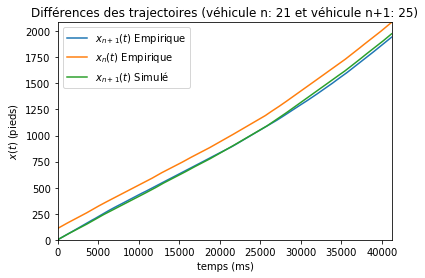

In [12]:
plt.plot(t, xNPlus1Empirique, label = r'$x_{n+1}(t)$ Empirique')
plt.plot(t, xN, label = r'$x_n(t)$ Empirique')
plt.plot(t, xNPlus1, label = r'$x_{n+1}(t)$ Simulé')

plt.xlabel("temps (ms)")
plt.ylabel(r'$x(t)$ (pieds)')
plt.title('Différences des trajectoires (véhicule n: %d et véhicule n+1: %d)'%(idN, idNplus1))
plt.legend(loc = 'best')
plt.axis([t_min, t_max, 0, xN[-1]])
# plt.savefig('Donnees_produites/Figures/trajectoires_premier_modele_GM_%d_%d.eps'%(idN, idNplus1), format='eps')
plt.show()

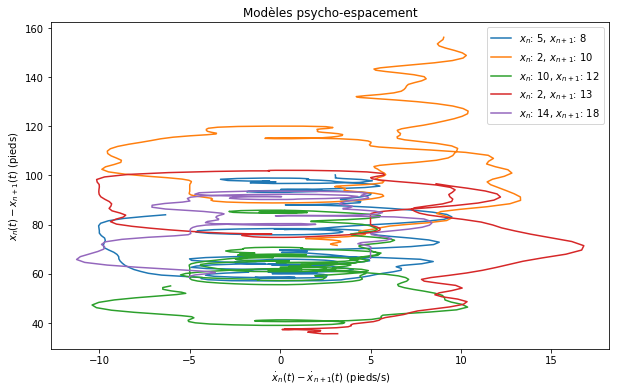

In [13]:
# Exercice 3
idN      = [5,2,10,2,14]
idNplus1 = [8,10,12,13,18]

plt.figure(figsize=(10,6))

for i in range(len(idN)):
    vehiculeN      = data.loc[(data['VehicleID'] == idN[i]) & (data['FollowingVehicle'] == idNplus1[i])] # n
    vehiculeNplus1 = data.loc[(data['VehicleID'] == idNplus1[i]) & (data['PrecedingVehicle'] == idN[i])] # n + 1

    expectedSpeedDiff = vehiculeN.VehicleVelocity.values - vehiculeNplus1.VehicleVelocity.values
    expectedSpacingDiff = vehiculeNplus1.Spacing.values
    
    labelStr = r'$x_n$: %d, x_{n+1}: %d'%(idN[i],idNplus1[i])

    plt.plot(expectedSpeedDiff, expectedSpacingDiff, label = r'$x_n$: %d, $x_{n+1}$: %d'%(idN[i],idNplus1[i]))

plt.xlabel(r'$\dot x_{n}(t) - \dot x_{n+1}(t)$ (pieds/s)')
plt.ylabel(r'$x_n(t) - x_{n+1}(t)$ (pieds)')
plt.title('Modèles psycho-espacement')
plt.legend(loc = 'best')
# plt.savefig('Donnees_produites/Figures/psycho_espacement.eps', format='eps')
plt.show()

In [14]:
# Exercice 4
def trouverTIVAcceptes(voieOrigine,voieDestination):
    frameChangementsVoies = []
    TIVAcceptes           = []

    vehiculeIDPrecedent = data.VehicleID[0]
    voiePrecedente      = data.LaneIdentification[0]

    for i in range(len(data)):
        vehiculeIDActuelle = data.VehicleID[i]
        voieActuelle       = data.LaneIdentification[i]

        # Détection d'un changement de voie
        if(voieActuelle == voieDestination and voiePrecedente == voieOrigine and vehiculeIDActuelle == vehiculeIDPrecedent):
            changementDeVoie = data.loc[(data.VehicleID == data.PrecedingVehicle[i]) & (data.FrameID == (data.FrameID[i]-1))]
            try:
                TIV = changementDeVoie.Headway.values[0]
                if(TIV != 0 and TIV != 9999.99):
                    TIVAcceptes.append(TIV)
            except:
                pass
        
        vehiculeIDPrecedent = vehiculeIDActuelle
        voiePrecedente      = voieActuelle
    
    return TIVAcceptes

In [15]:
TIV4_3 = trouverTIVAcceptes(4,3)
TIV5_4 = trouverTIVAcceptes(5,4)

In [16]:
len(TIV4_3)

122

In [17]:
len(TIV5_4)

147

In [18]:
from scipy import stats
stats.ks_2samp(TIV4_3,TIV5_4)

Ks_2sampResult(statistic=0.15233634437381505, pvalue=0.08182215537455954)

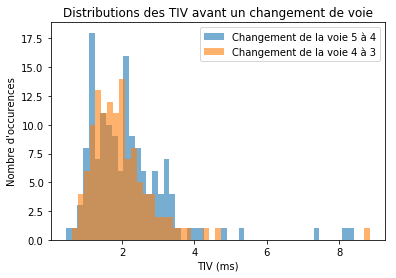

In [19]:
plt.hist(TIV5_4, bins = 50, alpha = 0.6, label = "Changement de la voie 5 à 4")
plt.hist(TIV4_3, bins = 50, alpha = 0.6, label = "Changement de la voie 4 à 3")
plt.xlabel("TIV (ms)")
plt.ylabel("Nombre d'occurences")
plt.title('Distributions des TIV avant un changement de voie')
plt.legend(loc = 'best')
# plt.savefig('Donnees_produites/Figures/distribution_TIV.png', format='png')
plt.show()